# RFECV multi-class prediction

In [1]:
import pathlib

import anndata
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix,
                             fbeta_score, make_scorer)
from sklearn.model_selection import StratifiedKFold

## Parameters

In [2]:
cluster_col = 'SubType'
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None

In [3]:
# Parameters
cluster_col = "SubType"
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None


In [4]:
output_dir = 'Model'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Marker Adata

In [5]:
adata = anndata.read_h5ad('Markers/cluster_markers.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 386 × 70 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'MajorRegion', 'SubRegion', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor'
    var: 'chrom', 'start', 'end'

## Cluster Order

In [7]:
if cluster_order_path is not None:
    cluster_order = pd.read_csv(cluster_order_path, header=None, index_col=0).index
else:
    cluster_order = sorted(adata.obs[cluster_col].unique())

## Supervise training

In [8]:
n_cell = adata.shape[0]
n_test = int(n_cell * test_portion)

In [9]:
# separate test and train
test_cells = adata.obs.sample(n_test, random_state=random_seed).index
test_judge = adata.obs_names.isin(test_cells)
train_judge = ~adata.obs_names.isin(test_cells)

In [10]:
test_df = pd.DataFrame(adata[test_judge, :].X,
                       index=adata.obs_names[test_judge],
                       columns=adata.var_names)
test_label = adata.obs.loc[test_judge, cluster_col]

train_df = pd.DataFrame(adata[train_judge, :].X,
                        index=adata.obs_names[train_judge],
                        columns=adata.var_names)
train_label = adata.obs.loc[train_judge, cluster_col]

## Training

In [11]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=n_jobs,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=10)

In [12]:
clf.fit(train_df, train_label)
joblib.dump(clf, 'Model/RFECV.lib')

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 6 of 100
building tree 7 of 100
building tree 5 of 100
building tree 10 of 100
building tree 3 of 100
building tree 9 of 100
building tree 4 of 100
building tree 8 of 100
building tree 13 of 100
building tree 11 of 100
building tree 12 of 100
building tree 16 of 100
building tree 17 of 100
building tree 19 of 100
building tree 18 of 100
building tree 15 of 100
building tree 21 of 100
building tree 14 of 100
building tree 23 of 100
building tree 22 of 100
building tree 28 of 100
building tree 30 of 100
building tree 20 of 100
building tree 27 of 100
building tree 24 of 100
building tree 25 of 100building tree 32 of 100

building tree 31 of 100
building tree 36 of 100
building tree 33 of 100building tree 26 of 100
building tree 37 of 100

building tree 35 of 100
building tree 34 of 100
building tree 29 of 100
building tree 42 of 100building tree 40 of 100
building tree 39 of 100building tree 38 of 100
building tree 45 of 100buil

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 100 of 100
building tree 96 of 100
building tree 3 of 100
building tree 7 of 100
building tree 6 of 100
building tree 4 of 100
building tree 2 of 100
building tree 9 of 100
building tree 5 of 100
building tree 10 of 100
building tree 12 of 100
building tree 1 of 100
building tree 8 of 100
building tree 11 of 100
building tree 13 of 100
building tree 17 of 100
building tree 16 of 100
building tree 20 of 100
building tree 18 of 100
building tree 22 of 100
building tree 21 of 100
building tree 15 of 100
building tree 23 of 100
building tree 14 of 100
building tree 25 of 100


building tree 27 of 100
building tree 19 of 100
building tree 31 of 100
building tree 26 of 100
building tree 24 of 100
building tree 29 of 100
building tree 28 of 100
building tree 33 of 100
building tree 34 of 100building tree 35 of 100

building tree 32 of 100
building tree 30 of 100
building tree 36 of 100
building tree 37 of 100
building tree 41 of 100
building tree 43 of 100building tree 40 of 100building tree 39 of 100

building tree 47 of 100

building tree 49 of 100building tree 38 of 100building tree 48 of 100


building tree 46 of 100building tree 42 of 100
building tree 45 of 100
building tree 52 of 100

building tree 44 of 100building tree 54 of 100building tree 57 of 100

building tree 53 of 100
building tree 51 of 100

building tree 55 of 100
building tree 50 of 100
building tree 58 of 100
building tree 56 of 100
building tree 59 of 100
building tree 63 of 100
building tree 60 of 100building tree 61 of 100building tree 62 of 100


building tree 69 of 100building tree 64 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.2s finished


['Model/RFECV.lib']

## Featurs

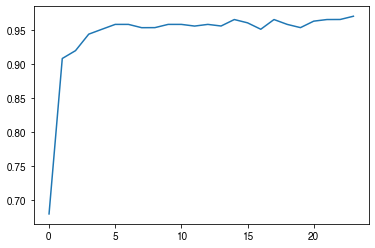

In [13]:
plt.plot(clf.grid_scores_)

In [14]:
feature_to_use = train_df.columns[clf.support_]
print(feature_to_use.size, 'features selected by RFECV')

70 features selected by RFECV


## Testing

In [15]:
# final pred
pred_label = clf.predict(test_df)

# final pred proba
pred_proba = clf.predict_proba(test_df)
pred_proba = pd.DataFrame(pred_proba, index=test_df.index, columns=clf.classes_)
pred_proba = pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished


In [16]:
balanced_accuracy_score(test_label, pred_label)

1.0

## Confusion matrix

In [17]:
cfm = confusion_matrix(test_label, pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 3)]

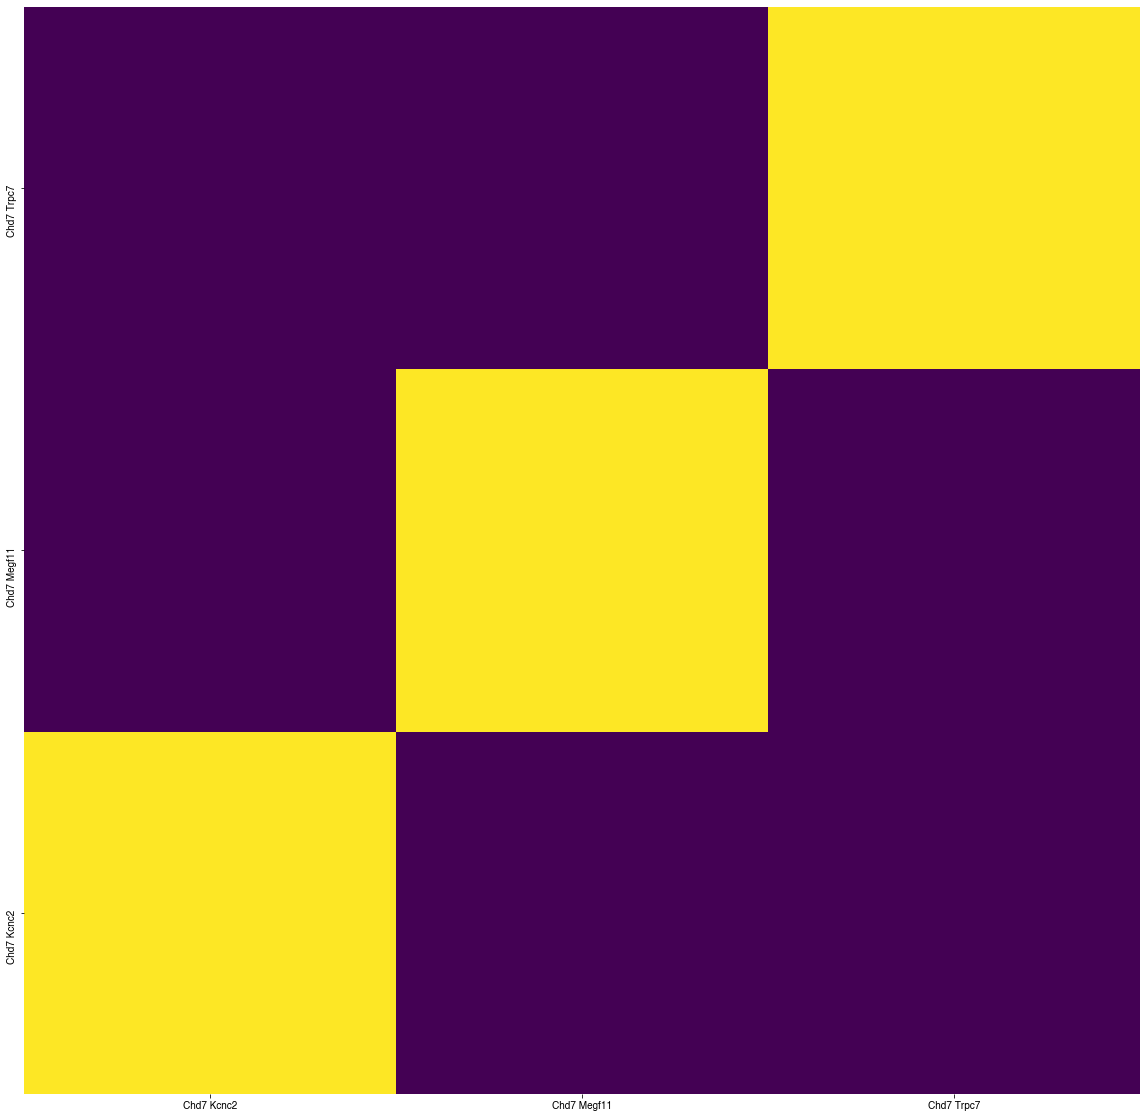

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [19]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = pred_proba.iloc[test_orders.argsort(), :]

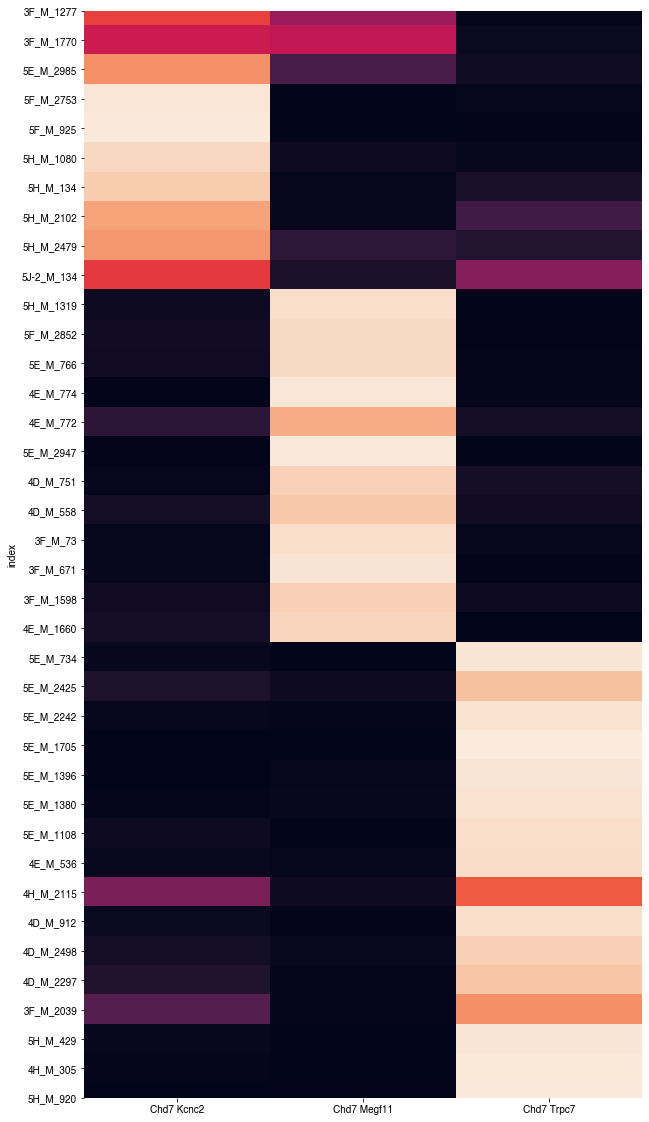

In [20]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

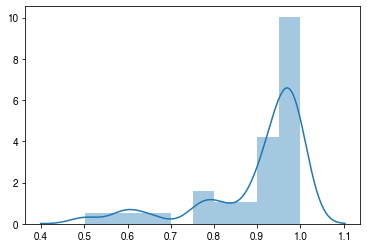

In [21]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

## Train final model with RFECV selected feature

In [22]:
selected_train_df = train_df.loc[:, feature_to_use]
selected_test_df = test_df.loc[:, feature_to_use]

In [23]:
# final estimator with larger trees
final_estimator = BalancedRandomForestClassifier(n_estimators=n_estimators_final,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 min_samples_split=2,
                                                 min_samples_leaf=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 bootstrap=True,
                                                 oob_score=False,
                                                 sampling_strategy='auto',
                                                 replacement=False,
                                                 n_jobs=n_jobs,
                                                 random_state=random_seed,
                                                 verbose=3,
                                                 warm_start=False,
                                                 class_weight=None)

In [24]:
final_estimator.fit(selected_train_df, train_label)
joblib.dump(final_estimator, 'Model/FinalClassifier.lib')

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.2s


building tree 4 of 500
building tree 3 of 500
building tree 1 of 500
building tree 9 of 500
building tree 10 of 500
building tree 2 of 500
building tree 13 of 500
building tree 12 of 500
building tree 5 of 500
building tree 6 of 500
building tree 11 of 500
building tree 8 of 500
building tree 16 of 500
building tree 14 of 500
building tree 15 of 500
building tree 7 of 500
building tree 20 of 500
building tree 23 of 500
building tree 22 of 500
building tree 19 of 500
building tree 17 of 500
building tree 18 of 500
building tree 26 of 500
building tree 28 of 500
building tree 25 of 500
building tree 24 of 500
building tree 27 of 500
building tree 21 of 500
building tree 29 of 500
building tree 30 of 500
building tree 35 of 500building tree 31 of 500
building tree 38 of 500
building tree 33 of 500
building tree 32 of 500

building tree 36 of 500
building tree 41 of 500
building tree 39 of 500building tree 34 of 500
building tree 37 of 500

building tree 40 of 500
building tree 42 of 500bu

building tree 100 of 500
building tree 104 of 500
building tree 105 of 500
building tree 110 of 500building tree 111 of 500
building tree 106 of 500
building tree 109 of 500
building tree 113 of 500
building tree 112 of 500
building tree 118 of 500building tree 107 of 500


building tree 116 of 500
building tree 115 of 500
building tree 120 of 500building tree 121 of 500
building tree 108 of 500
building tree 119 of 500

building tree 114 of 500building tree 128 of 500building tree 117 of 500


building tree 122 of 500
building tree 125 of 500building tree 129 of 500
building tree 126 of 500building tree 127 of 500
building tree 123 of 500


building tree 124 of 500building tree 130 of 500

building tree 132 of 500
building tree 131 of 500
building tree 134 of 500building tree 140 of 500
building tree 133 of 500building tree 137 of 500
building tree 138 of 500
building tree 139 of 500building tree 136 of 500building tree 135 of 500



building tree 141 of 500

building tree 143 of 500



building tree 194 of 500
building tree 202 of 500
building tree 204 of 500
building tree 200 of 500

building tree 205 of 500
building tree 199 of 500building tree 206 of 500

building tree 213 of 500building tree 208 of 500
building tree 212 of 500building tree 207 of 500

building tree 209 of 500building tree 210 of 500building tree 203 of 500
building tree 211 of 500

building tree 214 of 500


building tree 216 of 500building tree 217 of 500
building tree 218 of 500

building tree 215 of 500
building tree 220 of 500
building tree 222 of 500building tree 221 of 500building tree 219 of 500

building tree 225 of 500

building tree 224 of 500building tree 223 of 500

building tree 228 of 500
building tree 226 of 500
building tree 227 of 500
building tree 233 of 500
building tree 232 of 500building tree 231 of 500building tree 234 of 500building tree 235 of 500
building tree 236 of 500building tree 238 of 500



building tree 229 of 500

building tree 241 of 500building tree 230 of 500

[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.5s


building tree 303 of 500
building tree 300 of 500
building tree 309 of 500building tree 301 of 500building tree 298 of 500
building tree 302 of 500


building tree 310 of 500
building tree 307 of 500building tree 314 of 500

building tree 306 of 500building tree 308 of 500

building tree 305 of 500
building tree 304 of 500building tree 313 of 500

building tree 312 of 500building tree 317 of 500
building tree 315 of 500
building tree 322 of 500

building tree 321 of 500
building tree 316 of 500
building tree 311 of 500
building tree 319 of 500building tree 325 of 500

building tree 320 of 500
building tree 318 of 500building tree 323 of 500
building tree 326 of 500

building tree 324 of 500building tree 330 of 500

building tree 328 of 500
building tree 329 of 500building tree 332 of 500
building tree 331 of 500

building tree 334 of 500
building tree 333 of 500
building tree 335 of 500
building tree 327 of 500building tree 338 of 500

building tree 339 of 500building tree 336 of 500
b


building tree 402 of 500building tree 391 of 500building tree 395 of 500building tree 399 of 500

building tree 396 of 500

building tree 400 of 500building tree 390 of 500building tree 394 of 500


building tree 401 of 500

building tree 403 of 500
building tree 405 of 500building tree 404 of 500

building tree 406 of 500
building tree 407 of 500building tree 408 of 500
building tree 409 of 500

building tree 410 of 500
building tree 413 of 500
building tree 416 of 500building tree 414 of 500
building tree 418 of 500

building tree 412 of 500building tree 411 of 500

building tree 420 of 500building tree 415 of 500building tree 417 of 500

building tree 419 of 500building tree 423 of 500
building tree 422 of 500

building tree 424 of 500building tree 427 of 500


building tree 429 of 500
building tree 426 of 500building tree 433 of 500

building tree 425 of 500building tree 421 of 500
building tree 431 of 500
building tree 432 of 500

building tree 430 of 500
building tree 434 of 500

building tree 494 of 500
building tree 495 of 500building tree 491 of 500

building tree 496 of 500
building tree 499 of 500building tree 498 of 500building tree 497 of 500building tree 500 of 500





[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    1.1s finished


['Model/FinalClassifier.lib']

## Final Pred

In [25]:
final_pred_label = final_estimator.predict(selected_test_df)

final_pred_proba = final_estimator.predict_proba(selected_test_df)
final_pred_proba = pd.DataFrame(final_pred_proba, index=test_df.index, columns=clf.classes_)
final_pred_proba = final_pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.0s finished


In [26]:
balanced_accuracy_score(test_label, final_pred_label)

0.9666666666666667

## Final evaluate

In [27]:
cfm = confusion_matrix(test_label, final_pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 3)]

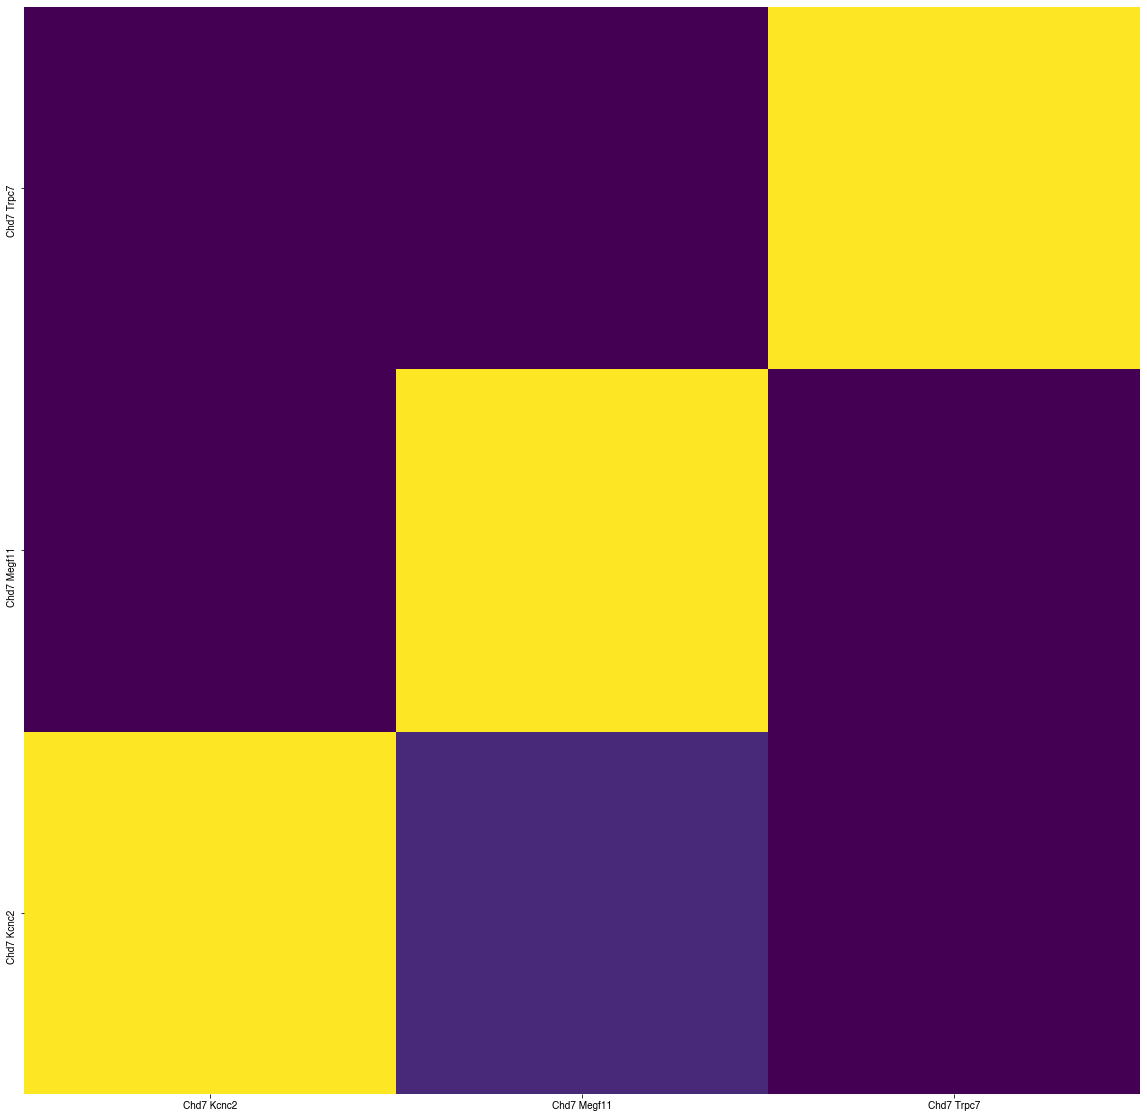

In [28]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [29]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = final_pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = final_pred_proba.iloc[test_orders.argsort(), :]

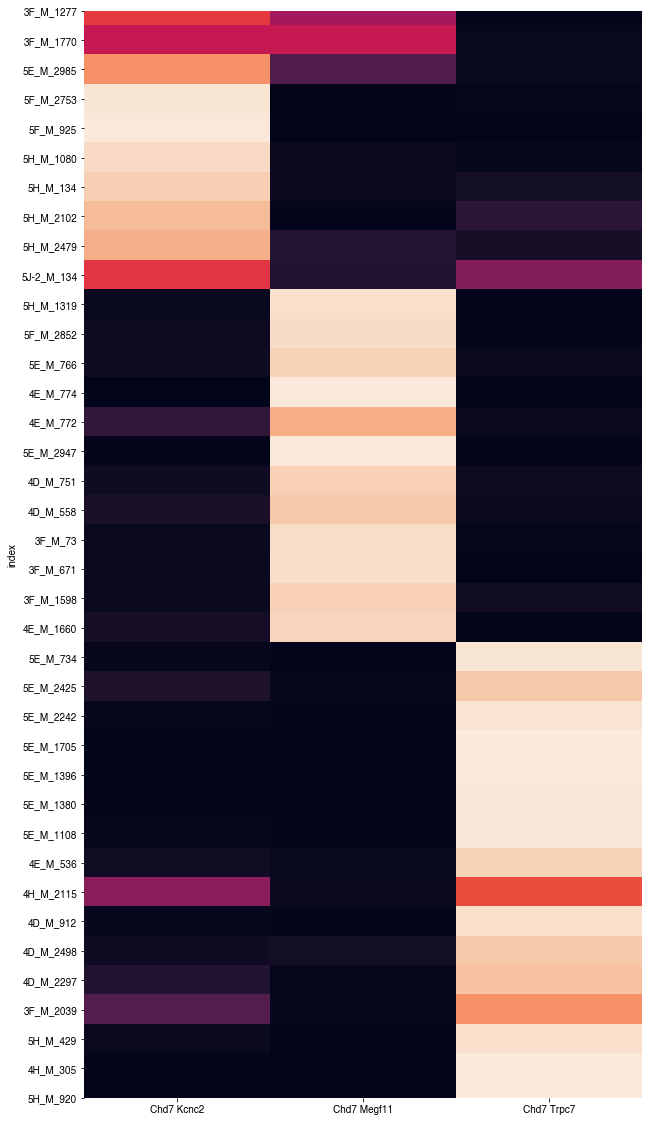

In [30]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

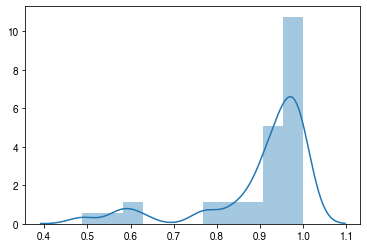

In [31]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

In [32]:
with open('finish_flag', 'w') as f:
    f.write('Oh yeah')